In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime
from statsmodels.tsa.api import ExponentialSmoothing
import pymannkendall as mk
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Ram\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
C:\Users\Ram\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Ram\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
df = pd.read_csv('Cleaned_Dataset.csv.zip', compression = 'gzip')

# Creating Hourly Count of Trips

In [3]:
df['lpep_pickup_datetime'] = pd.to_datetime(df.lpep_pickup_datetime)
df['lpep_dropoff_datetime'] = pd.to_datetime(df.lpep_dropoff_datetime)
df['Date'] = pd.to_datetime(df.Date)

In [4]:
df['Date'] = pd.to_datetime(df['lpep_pickup_datetime'],errors='coerce').dt.date
df['Pickup_Time'] = pd.to_datetime(df['lpep_pickup_datetime']).dt.time
df['hourly_count'] = df.reset_index().index

In [5]:
df = df.groupby(pd.Grouper(key='lpep_pickup_datetime', axis=0, freq='H')).count()

In [6]:
df.reset_index(inplace=True, level=['lpep_pickup_datetime'])
df = df[['lpep_pickup_datetime','hourly_count']]

In [7]:
df['hour'] = df['lpep_pickup_datetime'].dt.hour
df['dayofweek'] = df['lpep_pickup_datetime'].dt.day_name()
df['week'] = df['lpep_pickup_datetime'].dt.isocalendar().week
df['mnth_yr'] = df['lpep_pickup_datetime'].dt.to_period('M')
df

,lpep_pickup_datetime,hourly_count,hour,dayofweek,week,mnth_yr
0,2019-01-01 00:00:00,1172,0,Tuesday,1,2019-01
1,2019-01-01 01:00:00,1199,1,Tuesday,1,2019-01
2,2019-01-01 02:00:00,1070,2,Tuesday,1,2019-01
3,2019-01-01 03:00:00,895,3,Tuesday,1,2019-01
4,2019-01-01 04:00:00,721,4,Tuesday,1,2019-01
...,...,...,...,...,...,...
26299,2021-12-31 19:00:00,124,19,Friday,52,2021-12
26300,2021-12-31 20:00:00,131,20,Friday,52,2021-12
26301,2021-12-31 21:00:00,95,21,Friday,52,2021-12
26302,2021-12-31 22:00:00,84,22,Friday,52,2021-12


# Visualizing the Data

(array([17897., 18017., 18140., 18262., 18383., 18506., 18628., 18748.,
        18871., 18993.]),
 [Text(17897.0, 0, '2019-01'),
  Text(18017.0, 0, '2019-05'),
  Text(18140.0, 0, '2019-09'),
  Text(18262.0, 0, '2020-01'),
  Text(18383.0, 0, '2020-05'),
  Text(18506.0, 0, '2020-09'),
  Text(18628.0, 0, '2021-01'),
  Text(18748.0, 0, '2021-05'),
  Text(18871.0, 0, '2021-09'),
  Text(18993.0, 0, '2022-01')])

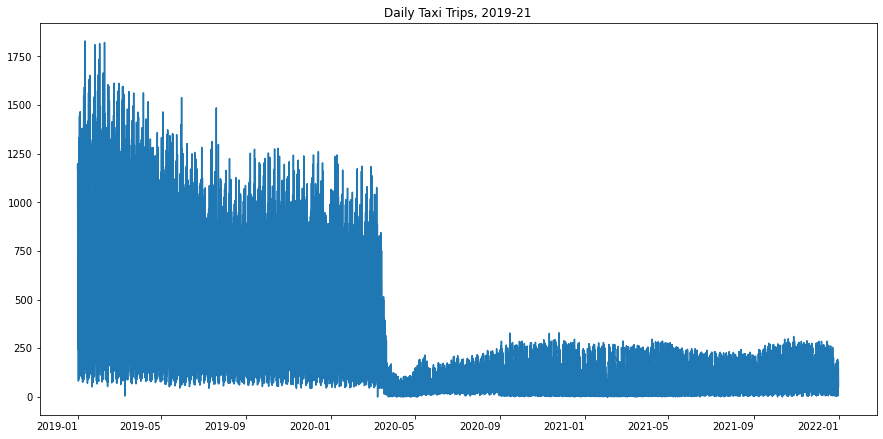

In [8]:
plt.plot(df['lpep_pickup_datetime'], df["hourly_count"])
plt.title("Daily Taxi Trips, 2019-21")
plt.gcf().autofmt_xdate()
plt.gcf().set_size_inches(15, 8)
plt.xticks(rotation=0)

In [9]:
df1 = df[(df['lpep_pickup_datetime'].dt.year==2021)]
df1.reset_index(drop=True,inplace=True)
df2 = df1[((df1['lpep_pickup_datetime'].dt.month == 12))]
df2.reset_index(drop=True,inplace=True)

(array([18962., 18966., 18970., 18974., 18978., 18982., 18986., 18990.,
        18993.]),
 [Text(18962.0, 0, '2021-12-01'),
  Text(18966.0, 0, '2021-12-05'),
  Text(18970.0, 0, '2021-12-09'),
  Text(18974.0, 0, '2021-12-13'),
  Text(18978.0, 0, '2021-12-17'),
  Text(18982.0, 0, '2021-12-21'),
  Text(18986.0, 0, '2021-12-25'),
  Text(18990.0, 0, '2021-12-29'),
  Text(18993.0, 0, '2022-01-01')])

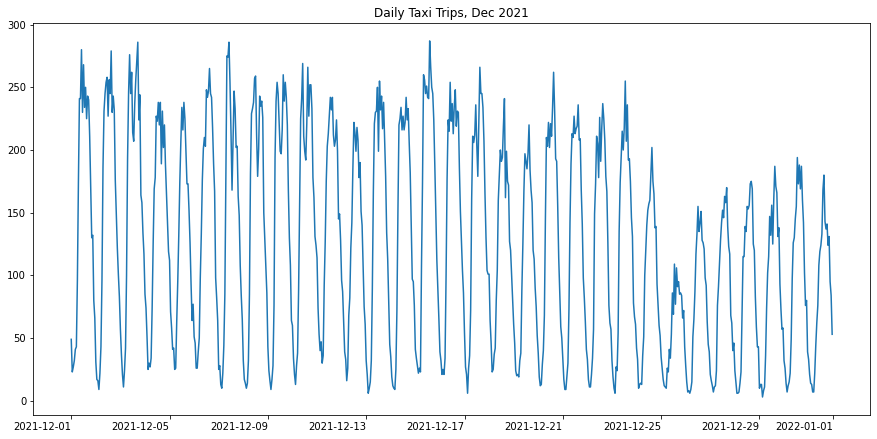

In [10]:
plt.plot(df2['lpep_pickup_datetime'], df2["hourly_count"])
plt.title("Daily Taxi Trips, Dec 2021")
plt.gcf().autofmt_xdate()
plt.gcf().set_size_inches(15, 8)
plt.xticks(rotation=0)

In [11]:
df3 = df2[(df2['lpep_pickup_datetime'].dt.day >= 9) & (df2['lpep_pickup_datetime'].dt.day <= 16)]
df3.reset_index(drop=True,inplace=True)
train = df3[(df3['lpep_pickup_datetime'].dt.day >= 9) & (df2['lpep_pickup_datetime'].dt.day <= 15)]
test = df3[(df3['lpep_pickup_datetime'].dt.day == 16)]
test.reset_index(drop=True,inplace=True)

<ipython-input-11-8c38f221c022>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train = df3[(df3['lpep_pickup_datetime'].dt.day >= 9) & (df2['lpep_pickup_datetime'].dt.day <= 15)]


# Time Series Components

In [12]:
ma = df3
ma['ma24'] = df3['hourly_count'].rolling(window = 24).mean()
ma['ma24'].dropna()
ma['cma24'] = ma['ma24'].rolling(window = 2).mean()
ma['cma24'].dropna()
ma = ma[['cma24']]
ma = ma.shift(-12, axis = 0)
ma['lpep_pickup_datetime'] = df3['lpep_pickup_datetime']

<ipython-input-12-5f4d6f5e9d98>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ma['ma24'] = df3['hourly_count'].rolling(window = 24).mean()
<ipython-input-12-5f4d6f5e9d98>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ma['cma24'] = ma['ma24'].rolling(window = 2).mean()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(array([18970., 18971., 18972., 18973., 18974., 18975., 18976., 18977.,
        18978.]),
 [Text(18970.0, 0, '2021-12-09'),
  Text(18971.0, 0, '2021-12-10'),
  Text(18972.0, 0, '2021-12-11'),
  Text(18973.0, 0, '2021-12-12'),
  Text(18974.0, 0, '2021-12-13'),
  Text(18975.0, 0, '2021-12-14'),
  Text(18976.0, 0, '2021-12-15'),
  Text(18977.0, 0, '2021-12-16'),
  Text(18978.0, 0, '2021-12-17')])

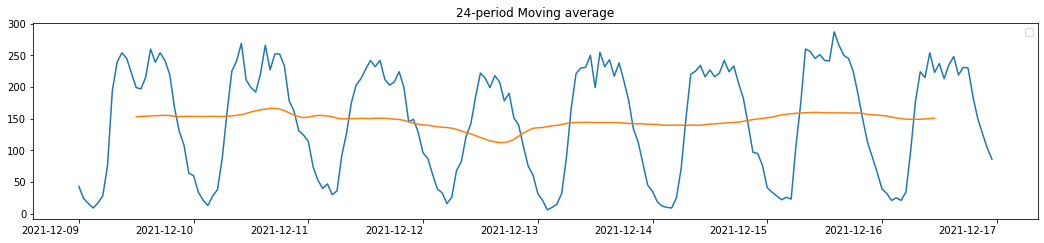

In [13]:
plt.plot(df3['lpep_pickup_datetime'], df3["hourly_count"])
plt.plot(ma['lpep_pickup_datetime'], ma["cma24"])
plt.title("24-period Moving average")
plt.legend()
plt.gcf().autofmt_xdate()
plt.gcf().set_size_inches(18, 4)
plt.xticks(rotation=0)

In [14]:
mk.original_test(df3["hourly_count"])

Mann_Kendall_Test(trend='no trend', h=False, p=0.49035128153343055, z=0.6897502149583223, Tau=0.033540575916230365, s=615.0, var_s=792415.6666666666, slope=0.05555555555555555, intercept=165.69444444444446)

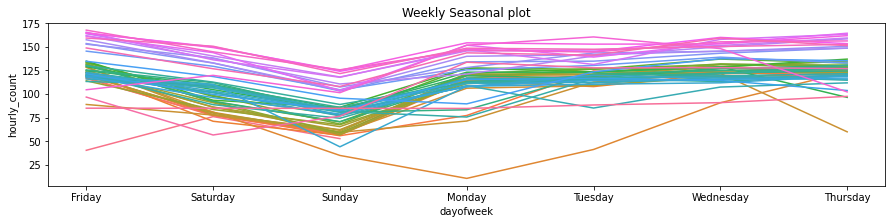

In [15]:
sns.lineplot(x=df1['dayofweek'], y=df1['hourly_count'], hue=df1['week'].astype(str), legend=None, ci=None)
plt.title('Weekly Seasonal plot')
plt.gcf().set_size_inches(15, 3)

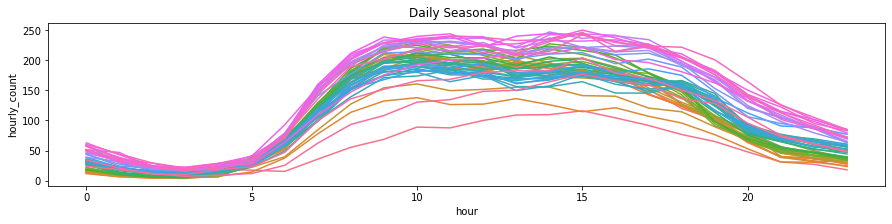

In [16]:
sns.lineplot(x=df1['hour'], y=df1['hourly_count'], hue=df1['week'].astype(str), legend=None, ci=None)
plt.title('Daily Seasonal plot')
plt.gcf().set_size_inches(15, 3)

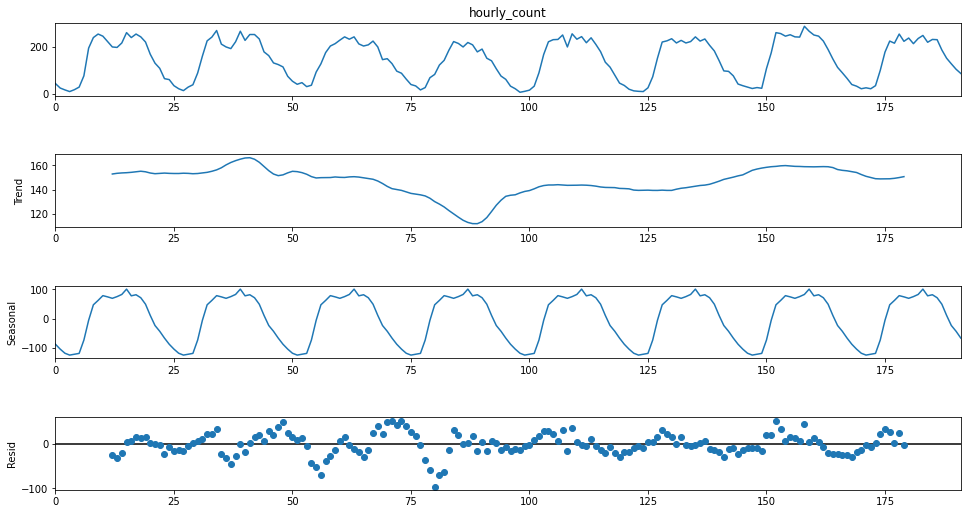

In [17]:
decomposition = sm.tsa.seasonal_decompose(df3["hourly_count"], model = 'add', period = 24)
decomposition.plot()
plt.gcf().set_size_inches(15, 8)

# Model Implementation

(array([18970., 18971., 18972., 18973., 18974., 18975., 18976., 18977.,
        18978.]),
 [Text(18970.0, 0, '2021-12-09'),
  Text(18971.0, 0, '2021-12-10'),
  Text(18972.0, 0, '2021-12-11'),
  Text(18973.0, 0, '2021-12-12'),
  Text(18974.0, 0, '2021-12-13'),
  Text(18975.0, 0, '2021-12-14'),
  Text(18976.0, 0, '2021-12-15'),
  Text(18977.0, 0, '2021-12-16'),
  Text(18978.0, 0, '2021-12-17')])

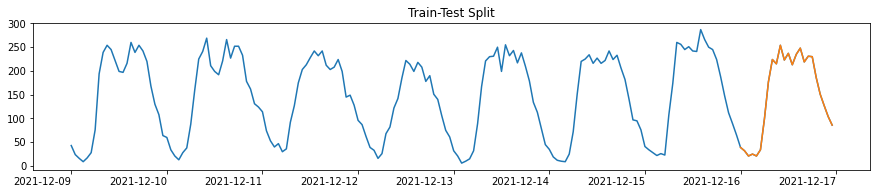

In [18]:
plt.plot(train['lpep_pickup_datetime'], train["hourly_count"])
plt.plot(test['lpep_pickup_datetime'], test["hourly_count"])
plt.title("Train-Test Split")
plt.gcf().autofmt_xdate()
plt.gcf().set_size_inches(15, 3)
plt.xticks(rotation=0)

In [19]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

# Baseline Model

In [20]:
snaive = df3
snaive['Actual'] = snaive['hourly_count']
snaive['Forecasted'] = snaive['hourly_count'].shift(24)
snaive2 = snaive.tail(len(test))

<ipython-input-20-8fb972045133>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snaive['Actual'] = snaive['hourly_count']
<ipython-input-20-8fb972045133>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snaive['Forecasted'] = snaive['hourly_count'].shift(24)


(array([18970., 18971., 18972., 18973., 18974., 18975., 18976., 18977.,
        18978.]),
 [Text(18970.0, 0, '2021-12-09'),
  Text(18971.0, 0, '2021-12-10'),
  Text(18972.0, 0, '2021-12-11'),
  Text(18973.0, 0, '2021-12-12'),
  Text(18974.0, 0, '2021-12-13'),
  Text(18975.0, 0, '2021-12-14'),
  Text(18976.0, 0, '2021-12-15'),
  Text(18977.0, 0, '2021-12-16'),
  Text(18978.0, 0, '2021-12-17')])

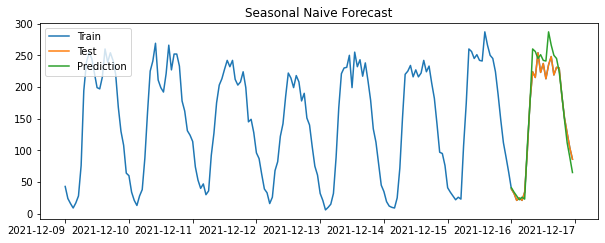

In [21]:
plt.plot(train['lpep_pickup_datetime'], train["hourly_count"])
plt.plot(snaive2['lpep_pickup_datetime'],snaive2['Actual'])
plt.plot(snaive2['lpep_pickup_datetime'],snaive2['Forecasted'])
plt.legend(["Train","Test", "Prediction"], loc ="upper left")
plt.title("Seasonal Naive Forecast")
plt.gcf().autofmt_xdate()
plt.gcf().set_size_inches(10, 4)
plt.xticks(rotation=0)

(array([-5.,  0.,  5., 10., 15., 20., 25.]),
 [Text(-5.0, 0, '−5'),
  Text(0.0, 0, '0'),
  Text(5.0, 0, '5'),
  Text(10.0, 0, '10'),
  Text(15.0, 0, '15'),
  Text(20.0, 0, '20'),
  Text(25.0, 0, '25')])

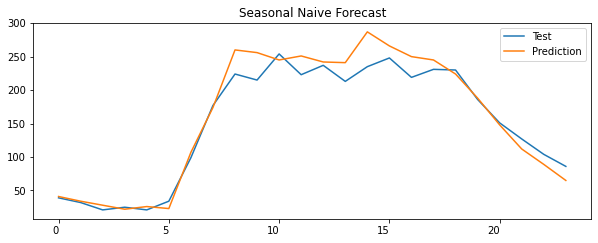

In [22]:
plt.plot(snaive2['hour'],snaive2['Actual'])
plt.plot(snaive2['hour'],snaive2['Forecasted'])
plt.legend(["Test", "Prediction"], loc ="upper right")
plt.title("Seasonal Naive Forecast")
plt.gcf().autofmt_xdate()
plt.gcf().set_size_inches(10, 4)
plt.xticks(rotation=0)

In [23]:
MAPE(snaive2["Actual"],snaive2["Forecasted"])

12.294605590287599

# Exponential Smoothing

In [29]:
HWA = ExponentialSmoothing(train['hourly_count'], seasonal="add", seasonal_periods=24).fit()
HW = df3
HWApred = HWA.forecast(len(test))
HWApred.index = train.tail(len(test)).index
test = HWApred.index
HW['HWApred'] = HWApred
HW = HW.tail(len(test))

C:\Users\Ram\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
<ipython-input-29-7d9f037eb8bb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HW['HWApred'] = HWApred


In [30]:
print(HWA.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:             hourly_count   No. Observations:                  192
Model:             ExponentialSmoothing   SSE                          56152.542
Optimized:                         True   AIC                           1142.240
Trend:                             None   BIC                           1226.935
Seasonal:                      Additive   AICC                          1152.203
Seasonal Periods:                    24   Date:                 Tue, 22 Nov 2022
Box-Cox:                          False   Time:                         12:41:44
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9061566                alpha                 True
smoothing_seasonal       

In [31]:
MAPE(HW['HWApred'], HW['hourly_count'])

10.708537721575311

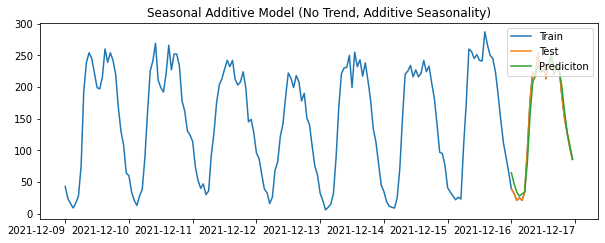

In [27]:
plt.plot(train['lpep_pickup_datetime'], train["hourly_count"], label = "Train")
plt.plot(HW['lpep_pickup_datetime'], HW["hourly_count"], label = "Test")
plt.plot(HW['lpep_pickup_datetime'], HW["HWApred"], label = "Prediciton")
plt.title("Seasonal Additive Model (No Trend, Additive Seasonality)")
plt.gcf().autofmt_xdate()
plt.gcf().set_size_inches(10, 4)
plt.xticks(rotation=0)
plt.legend(loc ="upper right")

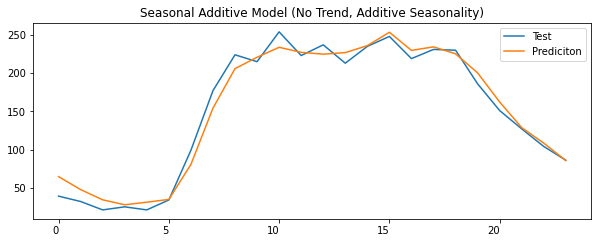

In [28]:
plt.plot(HW['hour'], HW["hourly_count"], label = "Test")
plt.plot(HW['hour'], HW["HWApred"], label = "Prediciton")
plt.title("Seasonal Additive Model (No Trend, Additive Seasonality)")
plt.gcf().autofmt_xdate()
plt.gcf().set_size_inches(10, 4)
plt.xticks(rotation=0)
plt.legend(loc ="upper right")